<a href="https://colab.research.google.com/github/kasettilameri/firebase-bookstore/blob/main/hugging_face_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Facial Hair Editor — Google Colab Notebook

# This notebook creates **four realistic edits** of your photo using Stable Diffusion **inpainting**:

# 1. **No beard (keep moustache)**
# 2. **No moustache (keep beard)**
# 3. **Clean-shaven (no beard or moustache)**
# 4. **Surprise variant (goatee style)**

# **Setup:**
# - Go to **Runtime -> Change runtime type -> GPU** in Colab.
# - You need a free [Hugging Face account](https://huggingface.co/) and a token (from [huggingface.co/settings/tokens](https://huggingface.co/settings/tokens)) to use the model.

In [ ]:
# 🔧 Clean slate (remove conflicting versions)
!pip -q uninstall -y diffusers accelerate transformers sentence-transformers

# 🧱 Install compatible stack for Colab (Py3.12 + CUDA 12.1)
!pip -q install --upgrade pip
!pip -q install torch --index-url https://download.pytorch.org/whl/cu121

# ✅ Known-good versions that work together
!pip -q install "diffusers==0.30.3" "accelerate==0.31.0" "transformers==4.44.2" "safetensors>=0.4.2"

# 📦 Other deps
!pip -q install "mediapipe==0.10.14" "opencv-python" "pillow" "numpy" "tqdm"

In [ ]:

# 🔹 Install dependencies (with pinned versions for Colab Python 3.12 compatibility)
!pip -q install --upgrade pip
!pip -q install torch --index-url https://download.pytorch.org/whl/cu121

# Compatible versions
!pip -q install diffusers==0.29.2
!pip -q install transformers==4.39.3
!pip -q install accelerate==0.27.2
!pip -q install safetensors==0.4.2
!pip -q install mediapipe==0.10.14 opencv-python pillow numpy tqdm

In [ ]:

# 🔹 2) Login to Hugging Face
import getpass, os
from huggingface_hub import login

if "HF_TOKEN" not in os.environ:
    token = getpass.getpass("Enter your Hugging Face token (from https://huggingface.co/settings/tokens): ")
    login(token=token, add_to_git_credential=False)
    os.environ["HF_TOKEN"] = token
else:
    login(token=os.environ["HF_TOKEN"], add_to_git_credential=False)

print("✅ Logged in to Hugging Face")

✅ Logged in to Hugging Face


In [1]:

# 🔹 3) Upload your face photo
from google.colab import files
from PIL import Image
import io

uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded. Please upload a face photo (JPG/PNG).")
name = list(uploaded.keys())[0]
image = Image.open(io.BytesIO(uploaded[name])).convert("RGB")
image_path = "input_photo.png"
image.save(image_path)
image

SystemExit: No file uploaded. Please upload a face photo (JPG/PNG).

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


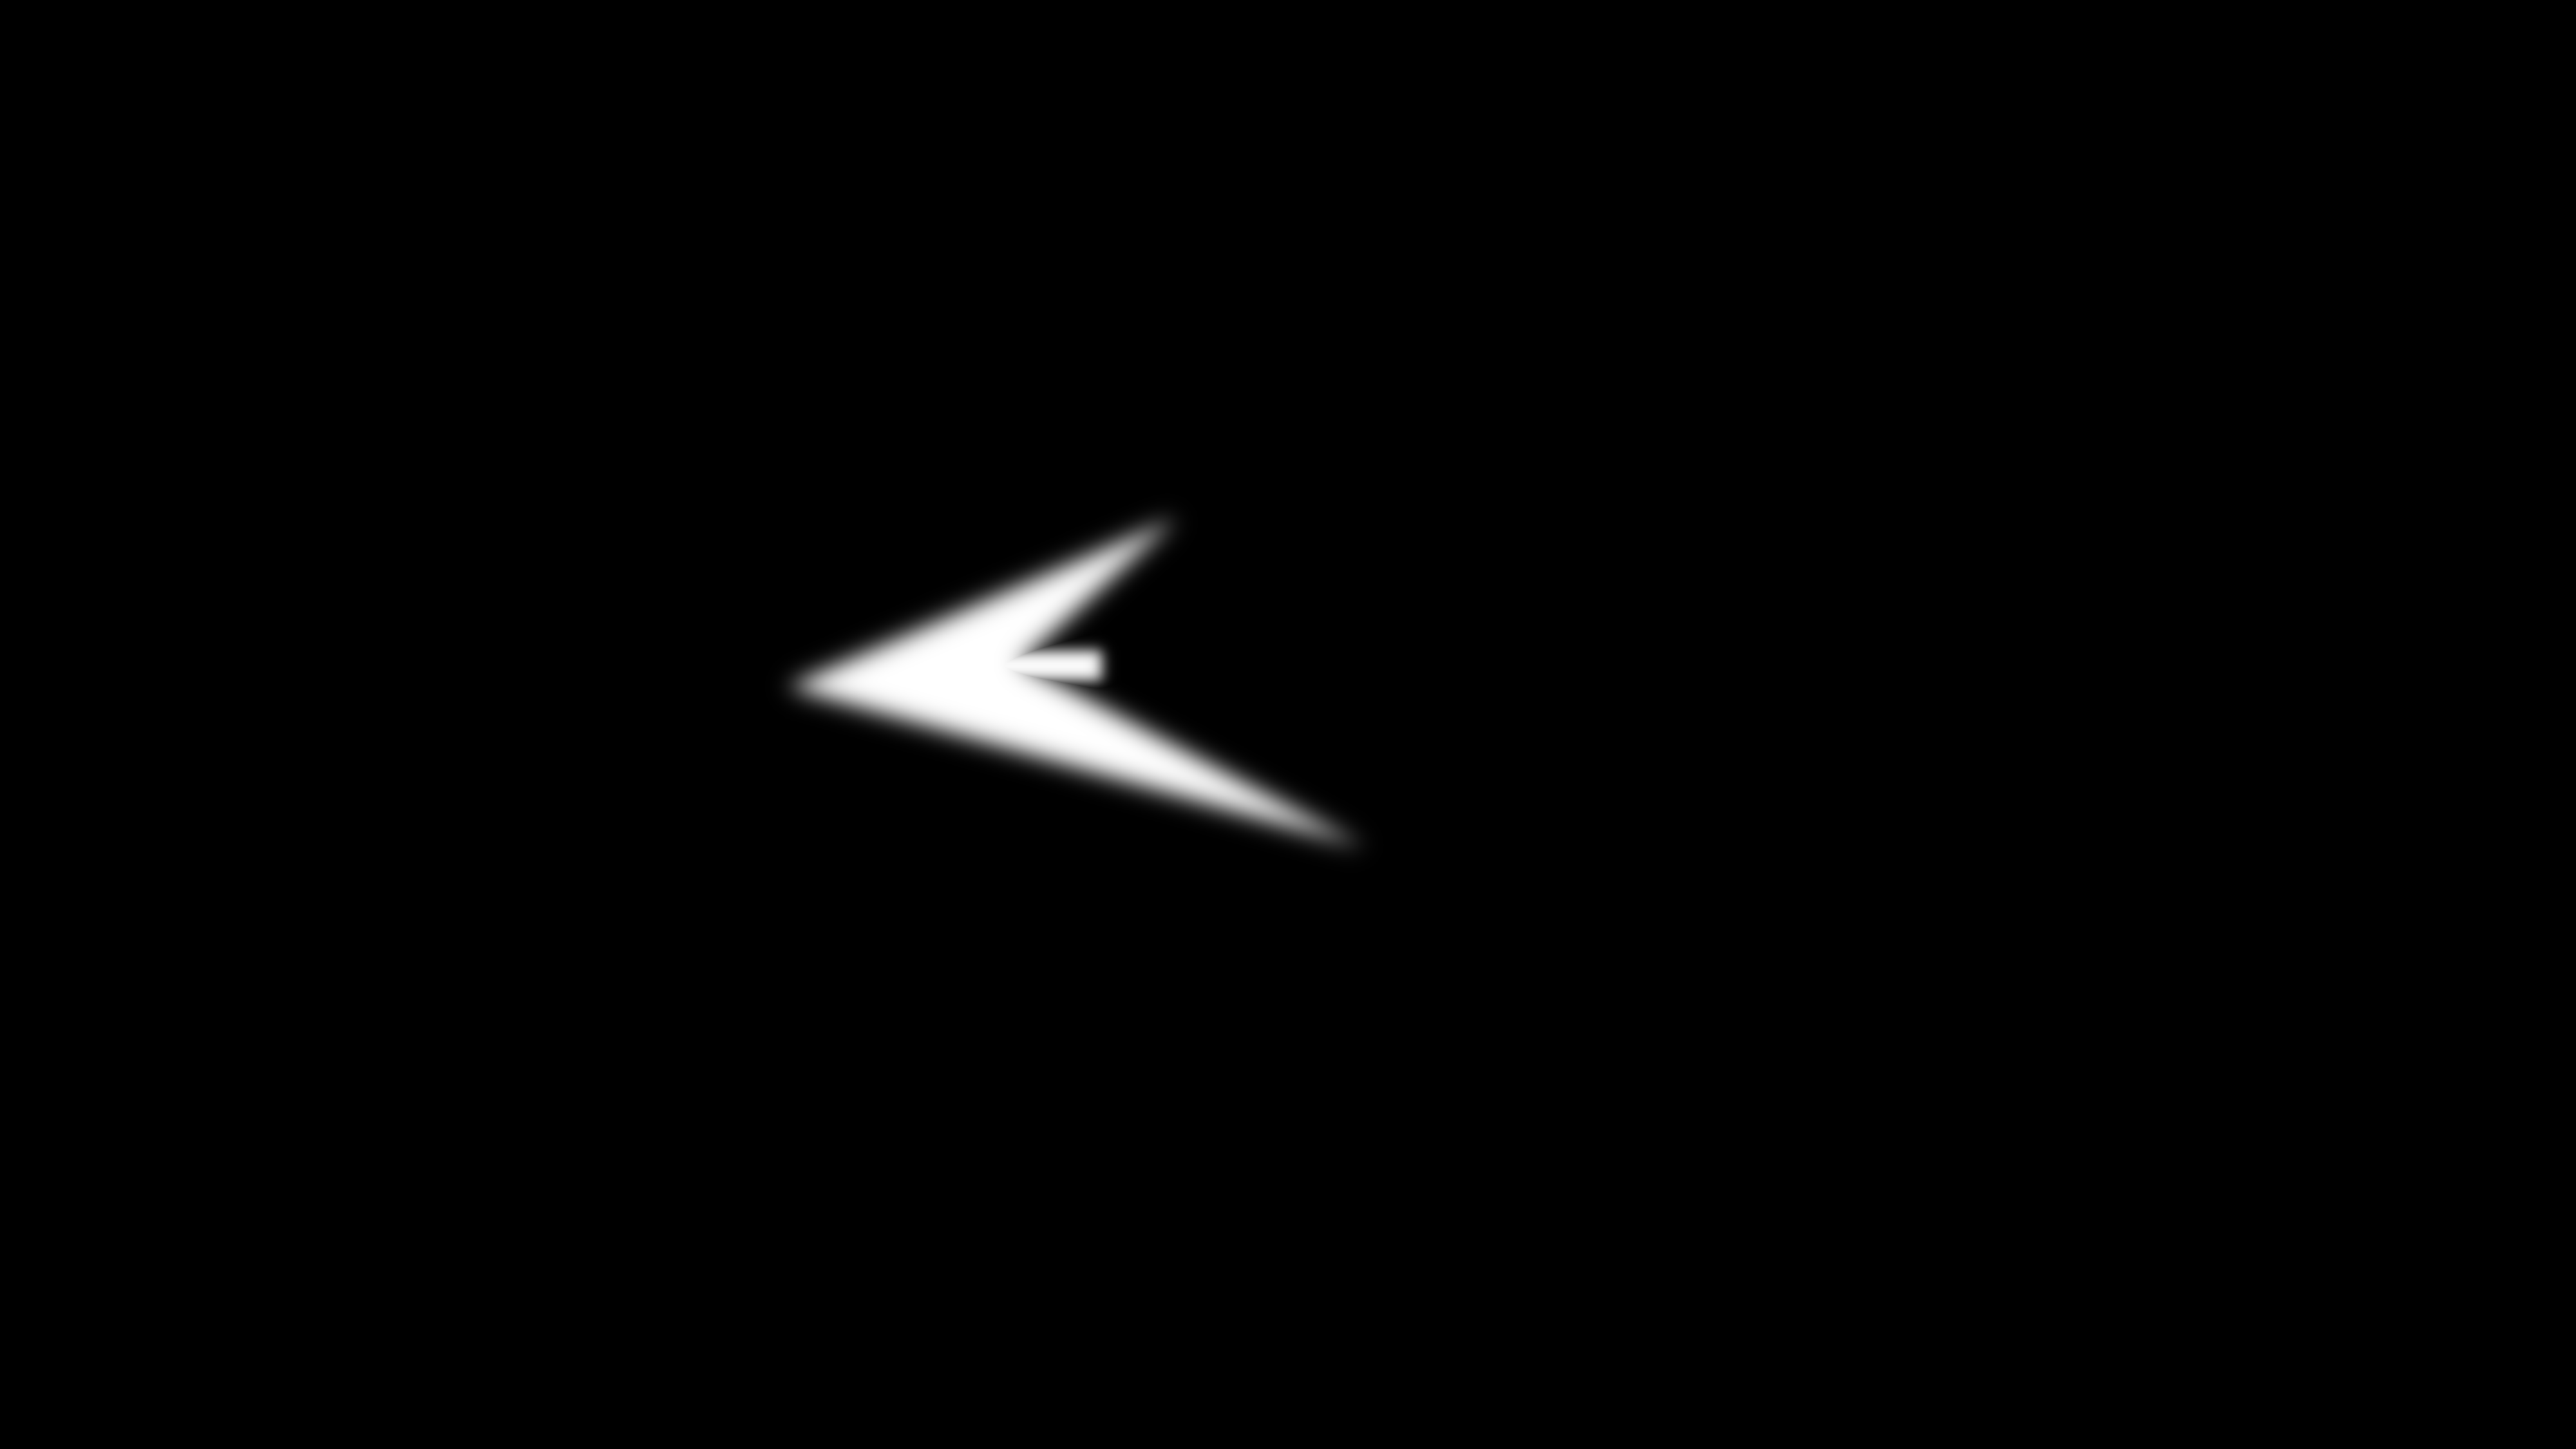

In [ ]:

# 🔹 4) Build masks with MediaPipe Face Mesh
import cv2, numpy as np
import mediapipe as mp
from PIL import Image

mp_face_mesh = mp.solutions.face_mesh

IDX = {
    "mouth_left": 61,
    "mouth_right": 291,
    "upper_lip_top": 13,
    "lower_lip_bottom": 14,
    "nose_tip": 1,
    "chin": 152,
    "left_jaw_near": 234,
    "right_jaw_near": 454
}

def detect_landmarks(image_pil):
    image_bgr = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
    h, w = image_bgr.shape[:2]
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5
    ) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            raise RuntimeError("No face detected. Try a clearer, front-facing photo with good lighting.")
        face_landmarks = results.multi_face_landmarks[0].landmark
        pts = np.array([[lm.x * w, lm.y * h] for lm in face_landmarks], dtype=np.float32)
        return pts, (h, w)

def feather_mask(mask, ksize=31):
    ksize = int(max(5, ksize) // 2 * 2 + 1)
    return cv2.GaussianBlur(mask, (ksize, ksize), 0)

def clamp(val, lo, hi):
    return max(lo, min(hi, val))

def build_moustache_mask(shape_hw, pts):
    h, w = shape_hw
    p_left = pts[IDX["mouth_left"]]; p_right = pts[IDX["mouth_right"]]
    p_upper = pts[IDX["upper_lip_top"]]; p_nose = pts[IDX["nose_tip"]]
    band_top_y = (p_nose[1] * 0.6 + p_upper[1] * 0.4)
    band_bottom_y = (p_nose[1] * 0.25 + p_upper[1] * 0.75) + 0.02 * h
    x1 = clamp(min(p_left[0], p_right[0]) - 0.03 * w, 0, w-1)
    x2 = clamp(max(p_left[0], p_right[0]) + 0.03 * w, 0, w-1)
    mask = np.zeros((h, w), dtype=np.uint8)
    poly = np.array([[x1, band_top_y],[x2, band_top_y],[x2, band_bottom_y],[x1, band_bottom_y]], dtype=np.int32)
    cv2.fillPoly(mask, [poly], 255)
    return feather_mask(mask, int(0.03 * min(h, w)))

def build_beard_mask(shape_hw, pts):
    h, w = shape_hw
    p_left = pts[IDX["mouth_left"]]; p_right = pts[IDX["mouth_right"]]
    p_lower = pts[IDX["lower_lip_bottom"]]; p_chin = pts[IDX["chin"]]
    p_lj = pts[IDX["left_jaw_near"]]; p_rj = pts[IDX["right_jaw_near"]]
    poly = np.array([
        [p_left[0], p_lower[1] + 0.01 * h],
        [p_lj[0] - 0.03 * w, (p_lj[1] + p_lower[1]) / 2 + 0.03 * h],
        [p_chin[0], p_chin[1] + 0.02 * h],
        [p_rj[0] + 0.03 * w, (p_rj[1] + p_lower[1]) / 2 + 0.03 * h],
        [p_right[0], p_lower[1] + 0.01 * h]
    ], dtype=np.int32)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [poly], 255)
    return feather_mask(mask, int(0.05 * min(h, w)))

def build_goatee_exclusion_mask(shape_hw, pts):
    h, w = shape_hw
    beard_mask = build_beard_mask(shape_hw, pts).copy()
    p_left = pts[IDX["mouth_left"]]; p_right = pts[IDX["mouth_right"]]
    p_lower = pts[IDX["lower_lip_bottom"]]; p_chin = pts[IDX["chin"]]
    center = (int((p_left[0] + p_right[0]) / 2), int((p_lower[1] + p_chin[1]) / 2))
    axes = (int((p_right[0] - p_left[0]) * 0.55), int((p_chin[1] - p_lower[1]) * 0.9))
    keep = np.zeros((h, w), dtype=np.uint8)
    cv2.ellipse(keep, center, axes, 0, 0, 360, 255, -1)
    cheeks_mask = cv2.subtract(beard_mask, keep)
    return feather_mask(cheeks_mask, int(0.05 * min(h, w)))

pts, (h, w) = detect_landmarks(image)
moustache_mask = build_moustache_mask((h, w), pts)
beard_mask = build_beard_mask((h, w), pts)
beard_minus_moustache = cv2.subtract(beard_mask, moustache_mask)
clean_mask = cv2.max(moustache_mask, beard_mask)
goatee_exclusion_mask = build_goatee_exclusion_mask((h, w), pts)

os.makedirs("outputs", exist_ok=True)
cv2.imwrite("outputs/mask_moustache.png", moustache_mask)
cv2.imwrite("outputs/mask_beard.png", beard_mask)
cv2.imwrite("outputs/mask_beard_minus_moustache.png", beard_minus_moustache)
cv2.imwrite("outputs/mask_clean_union.png", clean_mask)
cv2.imwrite("outputs/mask_goatee_exclusion.png", goatee_exclusion_mask)

Image.open("outputs/mask_clean_union.png")

In [ ]:

# 🔹 5) Inpaint with Stable Diffusion
from diffusers import StableDiffusionInpaintPipeline

MODEL_ID = "runwayml/stable-diffusion-inpainting"
STEPS = 40
GUIDANCE = 7.5
STRENGTH = 1.0
SEED = None

dtype = torch.float16 if torch.cuda.is_available() else torch.float32
pipe = StableDiffusionInpaintPipeline.from_pretrained(MODEL_ID, torch_dtype=dtype).to("cuda" if torch.cuda.is_available() else "cpu")
pipe.enable_attention_slicing("max")

PROMPTS = {
    "no_beard": {
        "positive": "natural skin, no beard, clear cheeks and jaw, realistic pores and texture, photographic, high quality",
        "negative": "beard, stubble, goatee, sideburns, facial hair, fake, blurry, low quality"
    },
    "no_moustache": {
        "positive": "natural skin on upper lip, no moustache, realistic pores and texture, photographic, high quality",
        "negative": "moustache, beard, stubble, facial hair, fake, blurry, low quality"
    },
    "clean_shaven": {
        "positive": "clean-shaven face, natural skin texture and pores, photographic, high quality",
        "negative": "beard, moustache, stubble, facial hair, fake, blurry, low quality"
    },
    "goatee_variant": {
        "positive": "defined goatee (moustache connected to chin), clean cheeks and jawline, realistic detail, photographic, high quality",
        "negative": "full beard, cheek beard, heavy stubble on cheeks, patchy, fake, blurry, low quality"
    }
}

def run_inpaint(image_pil, mask_np, prompt, negative):
    gen = None
    if SEED is not None:
        gen = torch.Generator(device=pipe.device).manual_seed(int(SEED))
    mask_pil = Image.fromarray(mask_np).convert("L")
    out = pipe(
        prompt=prompt,
        image=image_pil,
        mask_image=mask_pil,
        negative_prompt=negative,
        guidance_scale=GUIDANCE,
        num_inference_steps=STEPS,
        strength=STRENGTH,
        generator=gen
    )
    return out.images[0]

variants = [
    ("outputs/no_beard.png",          beard_minus_moustache, "no_beard"),
    ("outputs/no_moustache.png",      moustache_mask,        "no_moustache"),
    ("outputs/clean_shaven.png",      clean_mask,            "clean_shaven"),
    ("outputs/goatee_variant.png",    goatee_exclusion_mask, "goatee_variant"),
]

for path, mask_np, key in variants:
    print(f"Generating {path} ...")
    out = run_inpaint(image, mask_np, PROMPTS[key]["positive"], PROMPTS[key]["negative"])
    out.save(path)
print("✅ Done. Files saved in outputs/")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory' (/usr/local/lib/python3.12/dist-packages/accelerate/utils/memory.py)

In [ ]:
# 🔹 6) Preview results
from IPython.display import display
for p in [p for (p,_,_) in variants]:
    print(p)
    display(Image.open(p))